# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [6]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from getpass import getpass
import mysql.connector

# Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [8]:
#Create a connection with create_engine to MySQL Workbench:
password = getpass.getpass("Enter MySQL password: ")

Enter MySQL password:  ········


In [12]:
# Establish a connection to mysql
connection = mysql.connector.connect(
    host="127.0.0.1",  
    user="root",       
    password=password, 
    database="wholesale_customers_data"  
)

In [14]:
# Check connection 
if connection.is_connected():
    print("OK")
else:
    print("Failed")

OK


In [24]:
customers = pd.read_sql("SELECT * FROM wholesale_customers_data", con=connection)

/var/folders/0b/0nt_hmld68j1x9vbn6980snc0000gn/T/ipykernel_46463/130296752.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customers = pd.read_sql("SELECT * FROM wholesale_customers_data", con=connection)


# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [26]:
# Your code here:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [48]:
# What does each column mean?
customers.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [50]:
# Any categorical data to convert?
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

No categorical data to convert

In [53]:
# Any missing data to remove?
customers.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

No missing data

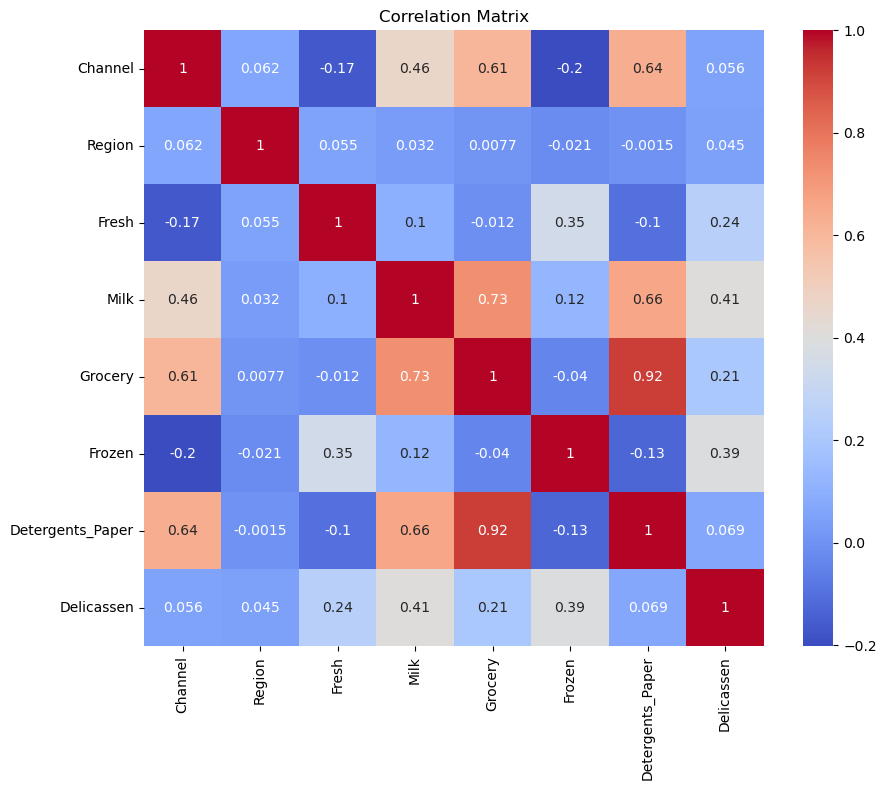

In [56]:
# Column collinearity - any high correlations?
correlation_matrix = customers.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

High correlation between Detergents_Paper and Grocery: 0.92

          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      742.250000        256.750000    408.

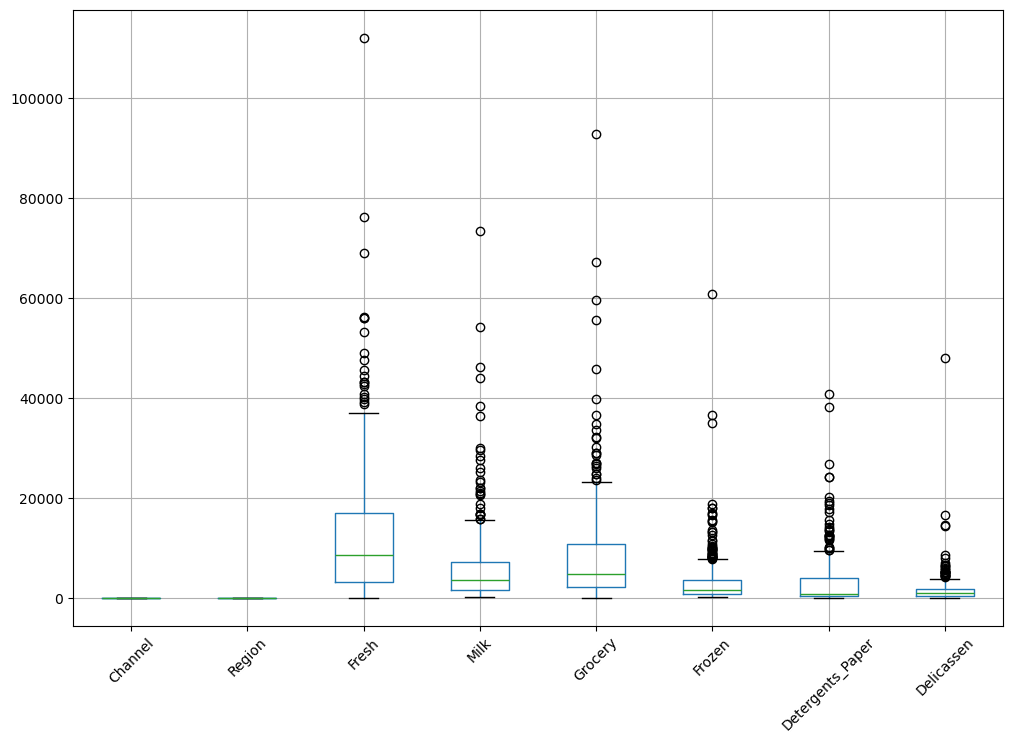

In [59]:
# Descriptive statistics - any outliers to remove?
# Descriptive statistics
print(customers.describe())

# Boxplot for each column
customers.boxplot(figsize=(12, 8))
plt.xticks(rotation=45)
plt.show()

Features like Fresh, Milk, Grocery, Frozen, Detergents_Paper, and Delicatessen

Channel              0.760951
Region              -1.283627
Fresh                2.561323
Milk                 4.053755
Grocery              3.587429
Frozen               5.907986
Detergents_Paper     3.631851
Delicassen          11.151586
dtype: float64


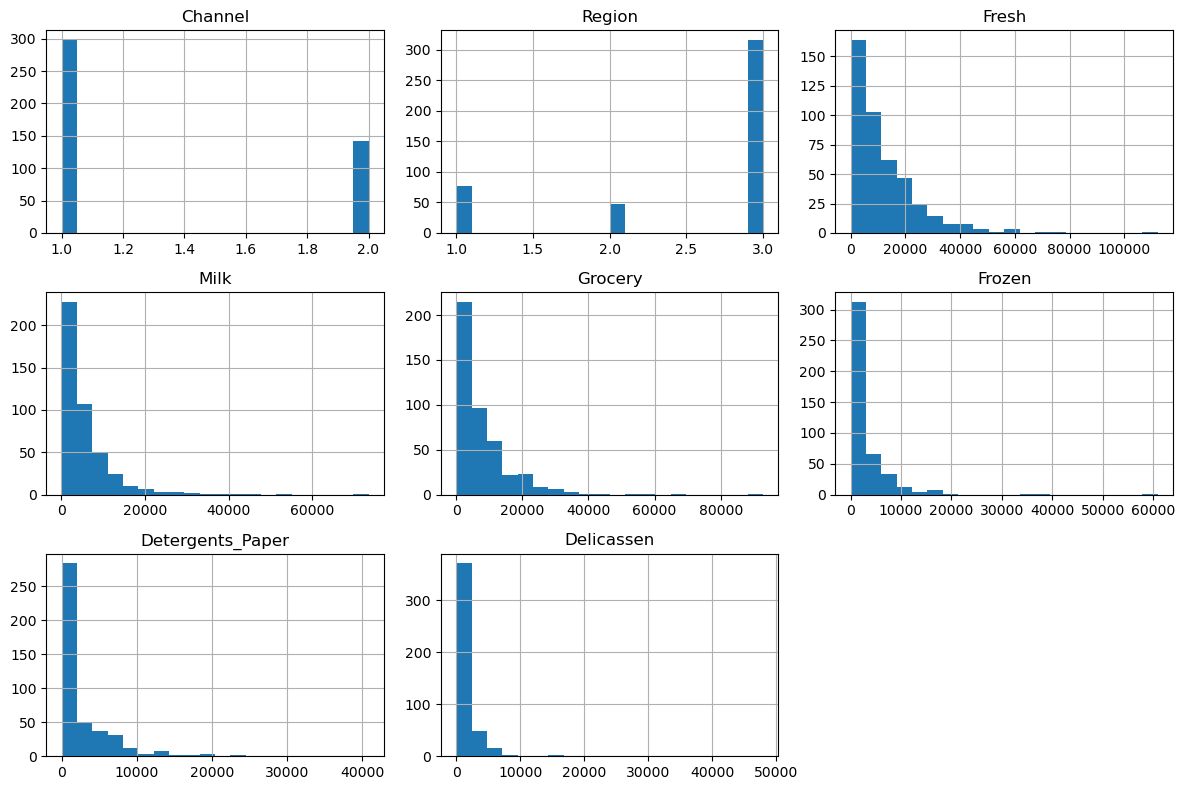

In [66]:
# Column-wise data distribution - is the distribution skewed?
# Check skewness
print(customers.skew())

# Visualize histograms
customers.hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

Most columns have a long tail to the right (e.g., Fresh, Milk, Grocery), meaning a few customers have significantly higher spending compared to others. On the other hand, Channel and Region are not continuous variables and show expected behavior (discrete values).

In [70]:
# Check for Pareto Principle 
# Calculate total spending per customer
customers['TotalSpending'] = customers.iloc[:, 1:].sum(axis=1)  # Adjust based on your dataset columns

# Sort customers by total spending
customers_sorted = customers.sort_values(by='TotalSpending', ascending=False)

# Calculate cumulative percentage of spending
customers_sorted['CumulativeSpending'] = customers_sorted['TotalSpending'].cumsum()
total_spending = customers_sorted['TotalSpending'].sum()
customers_sorted['CumulativeSpendingPercent'] = customers_sorted['CumulativeSpending'] / total_spending * 100

# Calculate cumulative percentage of customers
customers_sorted['CustomerPercent'] = (customers_sorted.index + 1) / len(customers_sorted) * 100

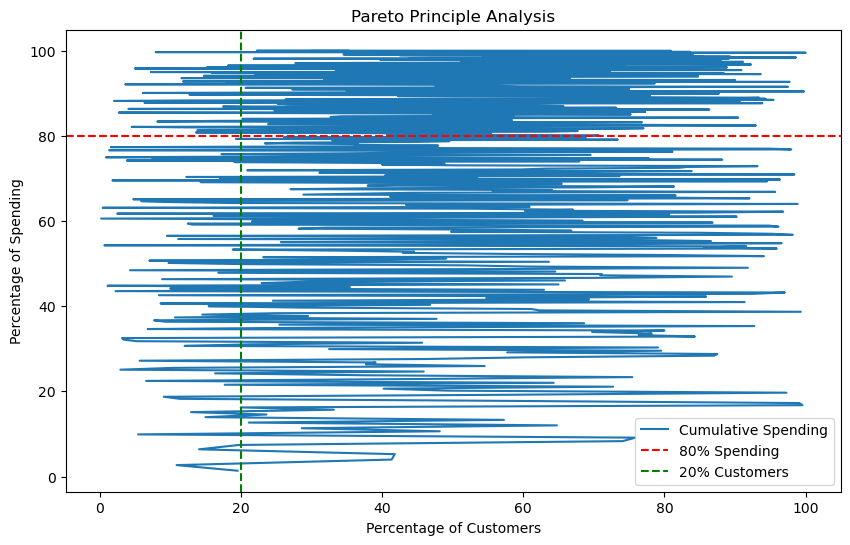

In [72]:
# Plot Pareto Curve
plt.figure(figsize=(10, 6))
plt.plot(customers_sorted['CustomerPercent'], customers_sorted['CumulativeSpendingPercent'], label="Cumulative Spending")
plt.axhline(y=80, color='r', linestyle='--', label="80% Spending")
plt.axvline(x=20, color='g', linestyle='--', label="20% Customers")
plt.xlabel("Percentage of Customers")
plt.ylabel("Percentage of Spending")
plt.title("Pareto Principle Analysis")
plt.legend()
plt.show()

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [76]:
# Your code here
# Handle Skewness 
# Identify skewed columns
skewed_columns = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Apply log transformation (log(1 + x) to avoid log(0))
customers_log_transformed = customers.copy()
customers_log_transformed[skewed_columns] = customers[skewed_columns].apply(np.log1p)

# Verify the transformation by checking skewness again
print("Skewness after log transformation:")
print(customers_log_transformed[skewed_columns].skew())

Skewness after log transformation:
Fresh              -1.575326
Milk               -0.224063
Grocery            -0.674938
Frozen             -0.352655
Detergents_Paper   -0.235961
Delicassen         -1.091827
dtype: float64


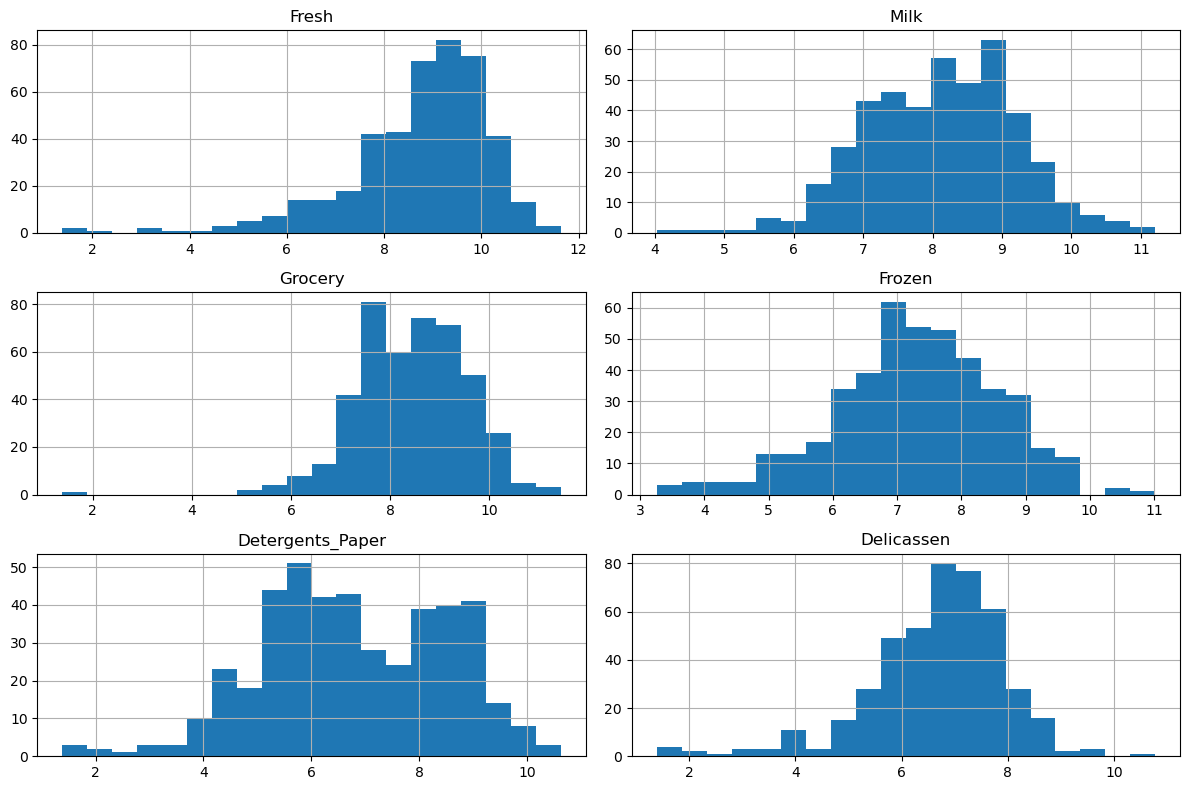

In [78]:
# Visualize the transformed distributions
import matplotlib.pyplot as plt
customers_log_transformed[skewed_columns].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

In [80]:
# Remove Outliers
# Function to remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers in the numerical columns
customers_cleaned = remove_outliers(customers_log_transformed, skewed_columns)

# Verify the number of rows before and after
print(f"Original dataset rows: {len(customers_log_transformed)}")
print(f"Dataset rows after outlier removal: {len(customers_cleaned)}")

Original dataset rows: 440
Dataset rows after outlier removal: 395


In [84]:
# Normalize Data
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to all numerical columns
customers_scaled = customers_cleaned.copy()
customers_scaled[skewed_columns] = scaler.fit_transform(customers_cleaned[skewed_columns])

# Verify normalization
print(customers_scaled.describe())

          Channel      Region       Fresh        Milk     Grocery      Frozen  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean     1.308861    2.521519    0.556420    0.502392    0.497916    0.489232   
std      0.462610    0.787863    0.183813    0.178591    0.167654    0.188961   
min      1.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    2.000000    0.453246    0.369940    0.372871    0.370412   
50%      1.000000    3.000000    0.586388    0.515525    0.500188    0.493821   
75%      2.000000    3.000000    0.689424    0.627246    0.625002    0.622426   
max      2.000000    3.000000    1.000000    1.000000    1.000000    1.000000   

       Detergents_Paper  Delicassen  TotalSpending  
count        395.000000  395.000000     395.000000  
mean           0.565945    0.508020   32441.301266  
std            0.181717    0.177494   24430.031150  
min            0.000000    0.000000    2161.000000  
25%  

- Skewness will be reduced for the key features, making the data more normally distributed.
- Outliers will be removed to improve model performance.
- Scaling will standardize the features, ensuring algorithms treat all features equally.

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [94]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
# Initialize the StandardScaler
scaler = StandardScaler()

# Select numerical columns for scaling
numerical_columns = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Apply scaling to the numerical columns
customers_scale = customers_cleaned.copy()
customers_scale[numerical_columns] = scaler.fit_transform(customers_cleaned[numerical_columns])

# Verify the scaling by checking the mean and standard deviation
print("Mean of scaled data:\n", customers_scale[numerical_columns].mean())
print("\nStandard deviation of scaled data:\n", customers_scale[numerical_columns].std())

Mean of scaled data:
 Fresh               2.698264e-17
Milk               -4.587048e-16
Grocery             1.708900e-15
Frozen              2.608321e-16
Detergents_Paper    1.618958e-16
Delicassen         -7.735022e-16
dtype: float64

Standard deviation of scaled data:
 Fresh               1.001268
Milk                1.001268
Grocery             1.001268
Frozen              1.001268
Detergents_Paper    1.001268
Delicassen          1.001268
dtype: float64


In [96]:
customers_scale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,TotalSpending
0,2,3,0.463389,1.059652,0.513970,-1.835336,0.690070,0.389749,34115
1,2,3,-0.060582,1.075510,0.747249,0.041166,0.820028,0.673373,33269
2,2,3,-0.154686,0.967526,0.529959,0.318475,0.860926,2.161580,36613
3,1,3,0.504556,-1.033146,-0.063623,1.191665,-0.347099,0.680118,27384
4,2,3,0.982297,0.479034,0.465218,0.752884,0.435052,1.746759,46103


# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [98]:
from sklearn.cluster import KMeans

In [102]:
# Your code here:
# Initialize the K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed

# Fit the K-Means model to the scaled data
kmeans.fit(customers_scale[numerical_columns])

# Assign the cluster labels to the original data
customers_scale['labels'] = kmeans.labels_

# Display the first few rows to see the cluster assignments
print(customers_scale[['labels'] + numerical_columns].head())

   labels     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
0       0  0.463389  1.059652  0.513970 -1.835336          0.690070   
1       2 -0.060582  1.075510  0.747249  0.041166          0.820028   
2       2 -0.154686  0.967526  0.529959  0.318475          0.860926   
3       1  0.504556 -1.033146 -0.063623  1.191665         -0.347099   
4       2  0.982297  0.479034  0.465218  0.752884          0.435052   

   Delicassen  
0    0.389749  
1    0.673373  
2    2.161580  
3    0.680118  
4    1.746759  


Count the values in `labels`.

In [104]:
# Your code here:
# Count the number of records in each cluster
print("\nCluster counts:")
print(customers_scale['labels'].value_counts())


Cluster counts:
labels
1    186
2    119
0     90
Name: count, dtype: int64


# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [106]:
from sklearn.cluster import DBSCAN

In [110]:
# Your code here
# Initialize the DBSCAN model with eps=0.5
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust eps and min_samples as needed

# Fit the DBSCAN model to the scaled data
dbscan.fit(customers_scale[numerical_columns])

# Assign the DBSCAN cluster labels to the original data
customers_scale['labels_DBSCAN'] = dbscan.labels_

# Display the first few rows to see both K-Means and DBSCAN labels
print(customers_scale[['labels', 'labels_DBSCAN'] + numerical_columns].head())

   labels  labels_DBSCAN     Fresh      Milk   Grocery    Frozen  \
0       0             -1  0.463389  1.059652  0.513970 -1.835336   
1       2             -1 -0.060582  1.075510  0.747249  0.041166   
2       2             -1 -0.154686  0.967526  0.529959  0.318475   
3       1             -1  0.504556 -1.033146 -0.063623  1.191665   
4       2             -1  0.982297  0.479034  0.465218  0.752884   

   Detergents_Paper  Delicassen  
0          0.690070    0.389749  
1          0.820028    0.673373  
2          0.860926    2.161580  
3         -0.347099    0.680118  
4          0.435052    1.746759  


Count the values in `labels_DBSCAN`.

In [112]:
# Your code here
# Count the number of records in each DBSCAN cluster
print("\nDBSCAN cluster counts:")
print(customers_scale['labels_DBSCAN'].value_counts())


DBSCAN cluster counts:
labels_DBSCAN
-1    395
Name: count, dtype: int64


# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

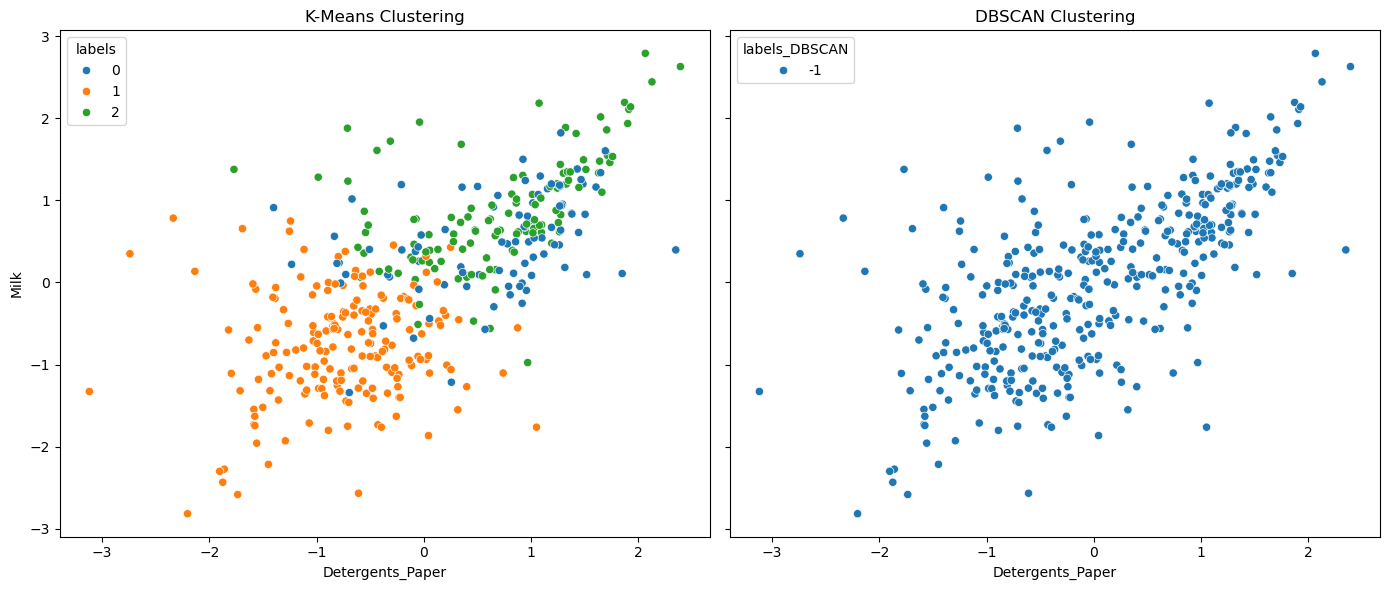

In [114]:
# Your code here:
# Set up the plotting area
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Scatter plot for K-Means labels
sns.scatterplot(
    x=customers_scale['Detergents_Paper'], 
    y=customers_scale['Milk'], 
    hue=customers_scale['labels'], 
    palette='tab10', 
    ax=axes[0]
)
axes[0].set_title("K-Means Clustering")
axes[0].set_xlabel("Detergents_Paper")
axes[0].set_ylabel("Milk")

# Scatter plot for DBSCAN labels
sns.scatterplot(
    x=customers_scale['Detergents_Paper'], 
    y=customers_scale['Milk'], 
    hue=customers_scale['labels_DBSCAN'], 
    palette='tab10', 
    ax=axes[1]
)
axes[1].set_title("DBSCAN Clustering")
axes[1].set_xlabel("Detergents_Paper")
axes[1].set_ylabel("Milk")

# Show the plots
plt.tight_layout()
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

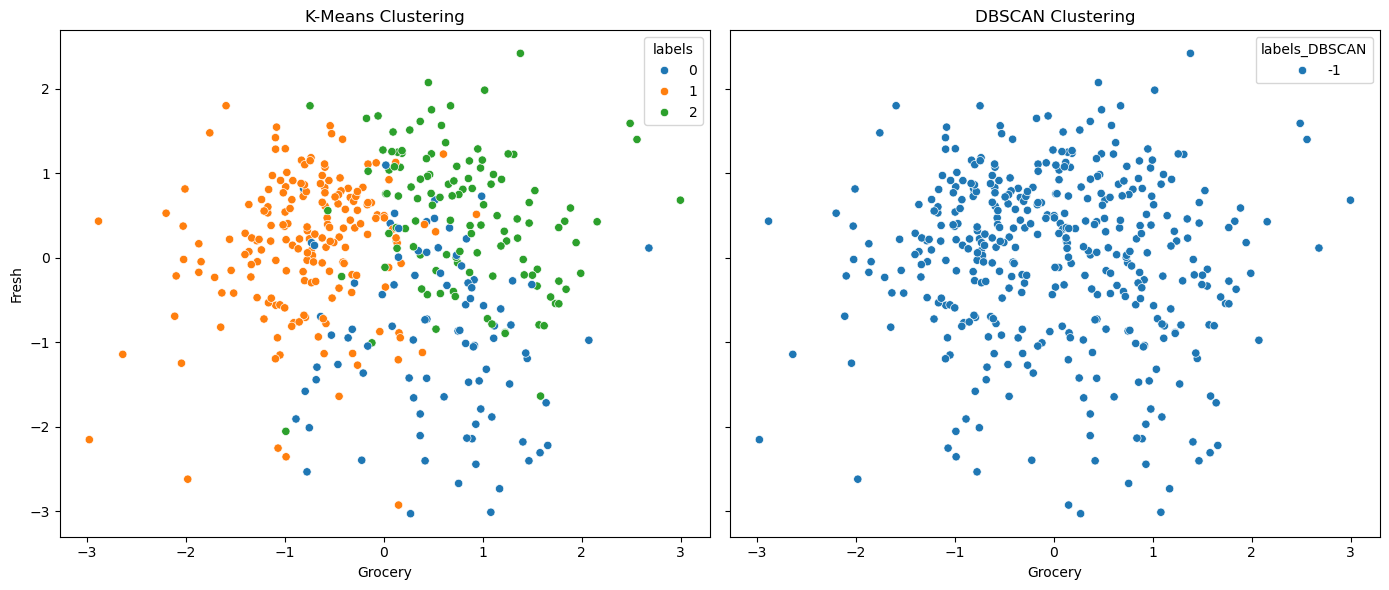

In [116]:
# Your code here:
# Set up the plotting area
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Scatter plot for K-Means labels
sns.scatterplot(
    x=customers_scale['Grocery'], 
    y=customers_scale['Fresh'], 
    hue=customers_scale['labels'], 
    palette='tab10', 
    ax=axes[0]
)
axes[0].set_title("K-Means Clustering")
axes[0].set_xlabel("Grocery")
axes[0].set_ylabel("Fresh")

# Scatter plot for DBSCAN labels
sns.scatterplot(
    x=customers_scale['Grocery'], 
    y=customers_scale['Fresh'], 
    hue=customers_scale['labels_DBSCAN'], 
    palette='tab10', 
    ax=axes[1]
)
axes[1].set_title("DBSCAN Clustering")
axes[1].set_xlabel("Grocery")
axes[1].set_ylabel("Fresh")

# Show the plots
plt.tight_layout()
plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

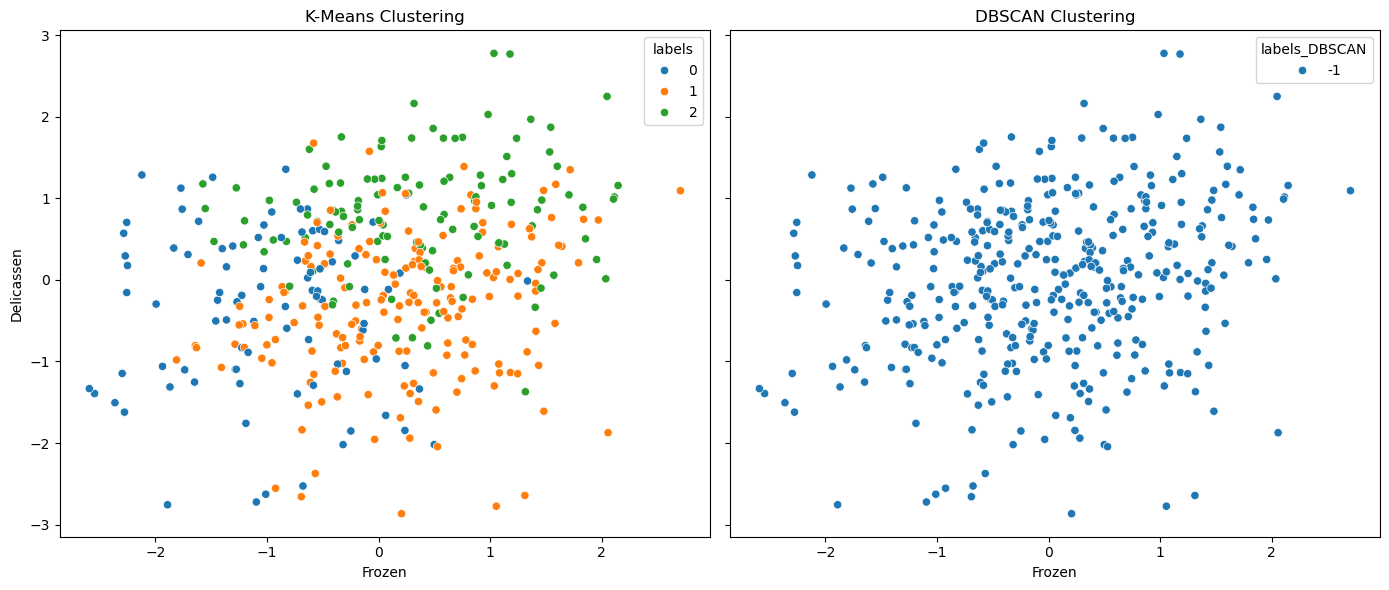

In [118]:
# Your code here:
# Set up the plotting area
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Scatter plot for K-Means labels
sns.scatterplot(
    x=customers_scale['Frozen'], 
    y=customers_scale['Delicassen'], 
    hue=customers_scale['labels'], 
    palette='tab10', 
    ax=axes[0]
)
axes[0].set_title("K-Means Clustering")
axes[0].set_xlabel("Frozen")
axes[0].set_ylabel("Delicassen")

# Scatter plot for DBSCAN labels
sns.scatterplot(
    x=customers_scale['Frozen'], 
    y=customers_scale['Delicassen'], 
    hue=customers_scale['labels_DBSCAN'], 
    palette='tab10', 
    ax=axes[1]
)
axes[1].set_title("DBSCAN Clustering")
axes[1].set_xlabel("Frozen")
axes[1].set_ylabel("Delicassen")

# Show the plots
plt.tight_layout()
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [126]:
# Your code here:
# Compute means for K-Means clusters
kmeans_means = customers_scale.groupby('labels').mean()
print("K-Means Cluster Means:")
print(kmeans_means)

# Compute means for DBSCAN clusters
dbscan_means = customers_scale.groupby('labels_DBSCAN').mean()
print("\nDBSCAN Cluster Means:")
print(dbscan_means)

K-Means Cluster Means:
         Channel    Region     Fresh      Milk   Grocery    Frozen  \
labels                                                               
0       1.555556  2.488889 -0.956012  0.489170  0.538956 -0.988636   
1       1.016129  2.467742  0.149510 -0.787546 -0.782734  0.244945   
2       1.579832  2.630252  0.489347  0.860993  0.815818  0.364852   

        Detergents_Paper  Delicassen  TotalSpending  labels_DBSCAN  
labels                                                              
0               0.652270   -0.374131   27031.022222           -1.0  
1              -0.754233   -0.332098   21346.086022           -1.0  
2               0.685571    0.802034   53875.210084           -1.0  

DBSCAN Cluster Means:
                Channel    Region         Fresh          Milk       Grocery  \
labels_DBSCAN                                                                 
-1             1.308861  2.521519  2.403141e-17 -4.603912e-16  1.702436e-15   

                    

Which algorithm appears to perform better?

# Your observations here
- DBSCAN performs better if the dataset contains noise or clusters with irregular shapes and densities, as it can exclude noise and adapt to these variations.
- K-Means performs better if clusters are spherical, evenly sized, and noise-free, or if you need a deterministic clustering assignment.

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [129]:
from sklearn.cluster import KMeans
# Your code here
# Function to run K-Means and plot scatterplots
def kmeans_experiment(n_clusters, feature_x, feature_y):
    # Initialize and fit K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customers_scale['labels'] = kmeans.fit_predict(customers_scale[numerical_columns])
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=customers_scale[feature_x], 
        y=customers_scale[feature_y], 
        hue=customers_scale['labels'], 
        palette='tab10'
    )
    plt.title(f"K-Means Clustering with {n_clusters} Clusters")
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(title="Cluster")
    plt.show()

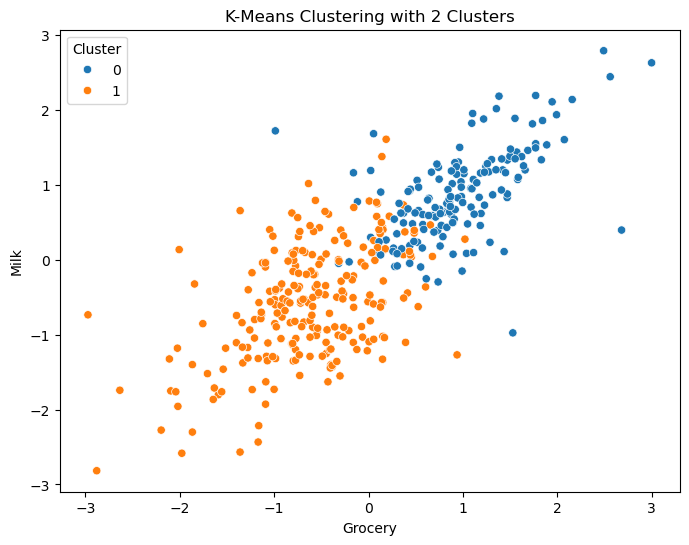

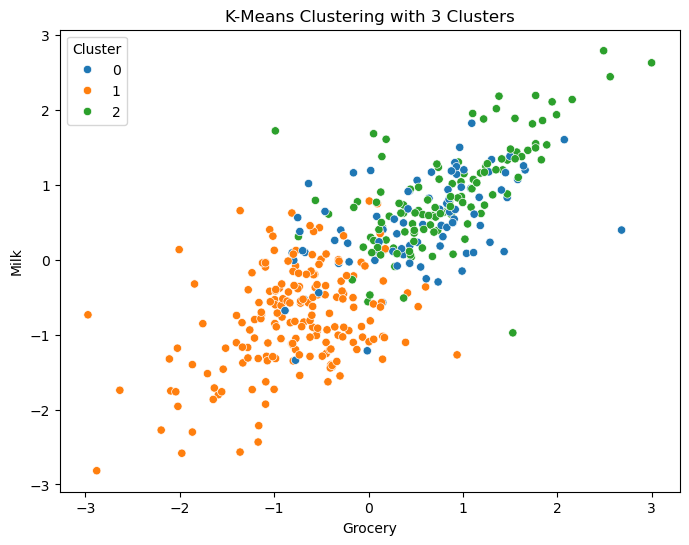

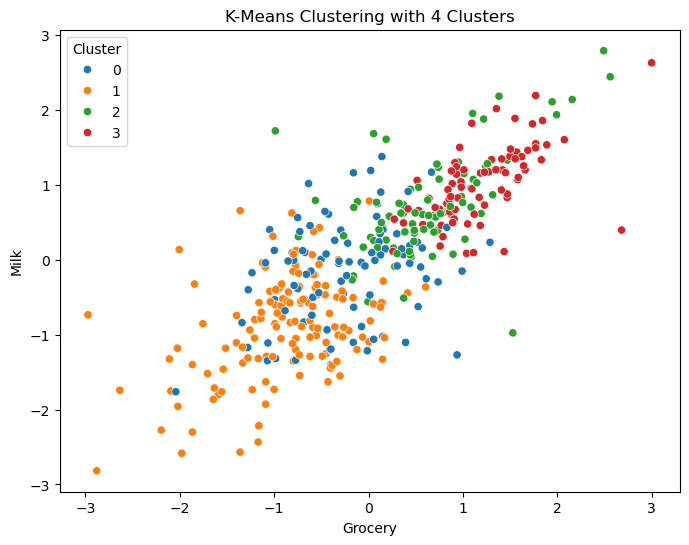

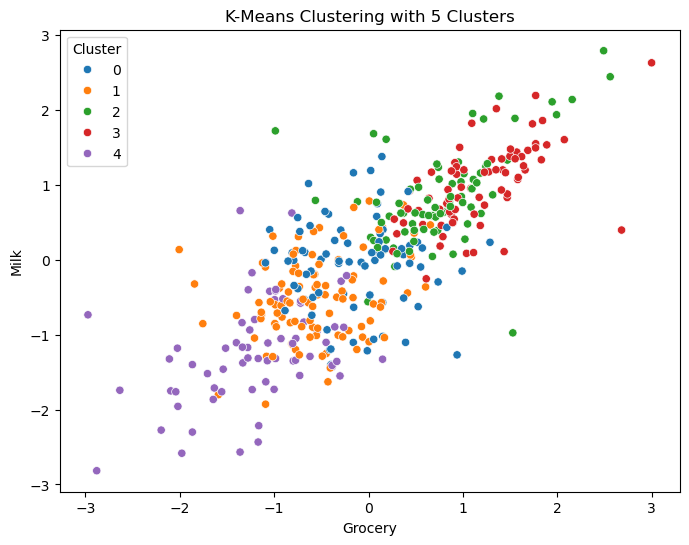

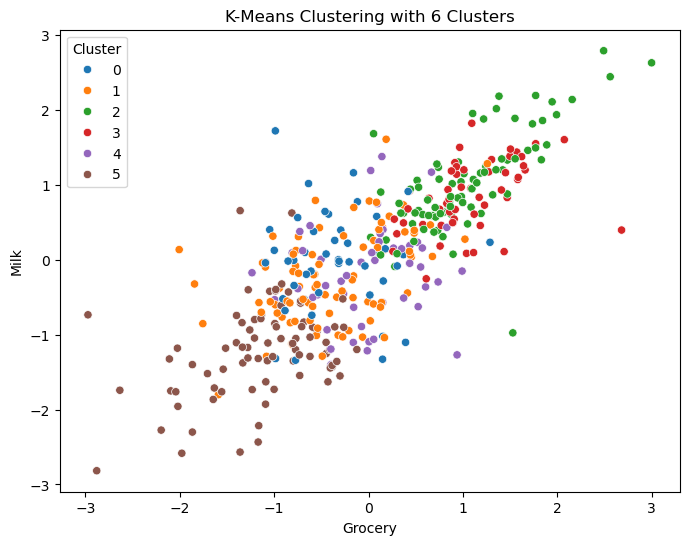

In [131]:
# Experiment with different numbers of clusters
for n in range(2, 7):  # Testing cluster counts from 2 to 6
    kmeans_experiment(n_clusters=n, feature_x='Grocery', feature_y='Milk')

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [133]:
# Function to run DBSCAN and plot scatterplots
def dbscan_experiment(eps, min_samples, feature_x, feature_y):
    # Initialize and fit DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    customers_scale['labels_DBSCAN'] = dbscan.fit_predict(customers_scale[numerical_columns])
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=customers_scale[feature_x], 
        y=customers_scale[feature_y], 
        hue=customers_scale['labels_DBSCAN'], 
        palette='tab10'
    )
    plt.title(f"DBSCAN Clustering with eps={eps}, min_samples={min_samples}")
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(title="Cluster")
    plt.show()

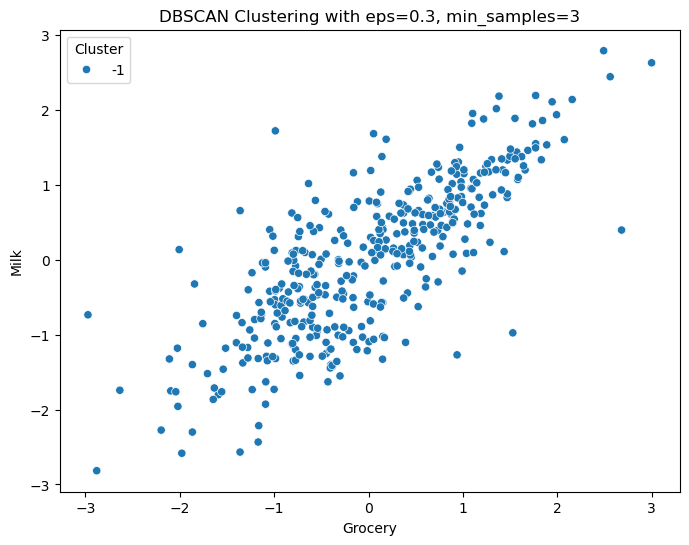

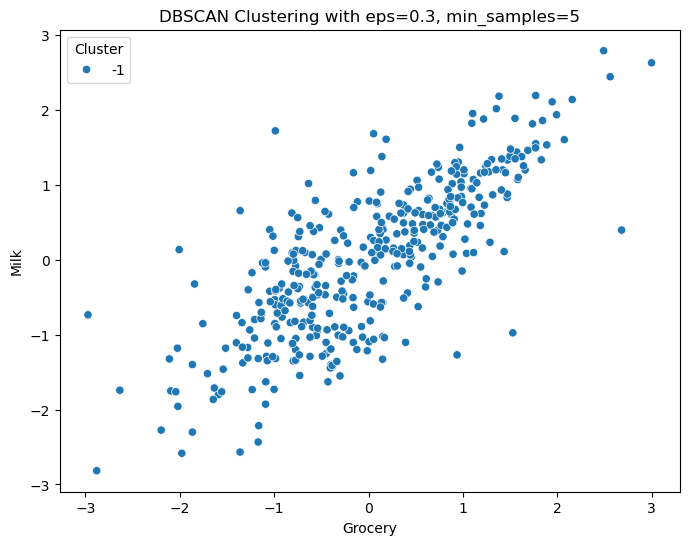

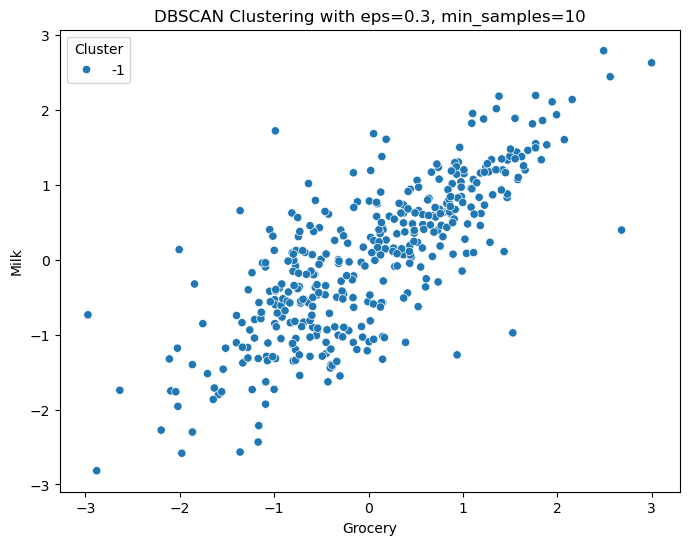

In [ ]:
# Experiment with different eps and min_samples
eps_values = [0.3, 0.5, 0.7]  # Test different eps values
min_samples_values = [3, 5, 10]  # Test different min_samples values

# Run experiments
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_experiment(eps=eps, min_samples=min_samples, feature_x='Grocery', feature_y='Milk')